In [12]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_predict
from sklearn.neighbors import KNeighborsClassifier
from ml_model_eval import pred_proba_plot, plot_cross_val_confusion_matrix, plot_learning_curve
# from ml_model_plot import plot_prediction_histogram, plot_cross_val_confusion_matrix, plot_learning_curve

In [2]:
matches = pd.read_csv("matches_after_preprocessing.csv", index_col=0)

In [3]:
matches

,date,time,round,day,venue,result,gf,ga,opponent,xg,...,hour,day_code,gf_rolling,ga_rolling,sh_rolling,sot_rolling,dist_rolling,fk_rolling,pk_rolling,pkatt_rolling
0,2018-09-02,13:30,Matchweek 4,Sun,Away,W,3.0,2.0,Cardiff City,1.7,...,13,6,1.666667,2.000000,13.666667,6.333333,18.166667,0.333333,0.000000,0.000000
1,2018-09-15,15:00,Matchweek 5,Sat,Away,W,2.0,1.0,Newcastle Utd,1.0,...,15,5,2.666667,2.000000,16.333333,9.000000,17.300000,0.333333,0.000000,0.000000
2,2018-09-23,16:00,Matchweek 6,Sun,Home,W,2.0,0.0,Everton,0.8,...,16,6,2.666667,1.333333,15.333333,7.666667,17.333333,0.666667,0.000000,0.000000
3,2018-09-29,15:00,Matchweek 7,Sat,Home,W,2.0,0.0,Watford,1.4,...,15,5,2.333333,1.000000,12.666667,6.000000,17.133333,0.333333,0.000000,0.000000
4,2018-10-07,12:00,Matchweek 8,Sun,Away,W,5.0,1.0,Fulham,1.1,...,12,6,2.000000,0.333333,10.000000,3.000000,16.666667,0.333333,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3648,2023-04-15,15:00,Matchweek 31,Sat,Home,W,2.0,0.0,Brentford,0.8,...,15,5,1.333333,1.666667,13.333333,4.333333,19.166667,0.333333,0.000000,0.000000
3649,2023-04-22,15:00,Matchweek 32,Sat,Away,L,1.0,2.0,Leicester City,0.9,...,15,5,1.333333,0.333333,9.333333,4.666667,19.933333,0.000000,0.000000,0.000000
3650,2023-04-25,19:30,Matchweek 33,Tue,Home,W,2.0,0.0,Crystal Palace,1.4,...,19,1,1.333333,0.666667,12.000000,5.333333,21.100000,0.666667,0.000000,0.000000
3651,2023-04-29,15:00,Matchweek 34,Sat,Away,L,0.0,6.0,Brighton,0.8,...,15,5,1.666667,0.666667,11.666667,4.666667,18.700000,0.666667,0.333333,0.333333


In [4]:
train = matches[matches["date"] < '2022-11-01']
test = matches[matches["date"] > '2022-11-01']

In [5]:
predictors = ["venue_code", "opp_code", "hour", "day_code", "gf_rolling", "ga_rolling", "sh_rolling", "sot_rolling", "dist_rolling", "fk_rolling", "pk_rolling", "pkatt_rolling"]
X_train = train[predictors]
y_train = train["target"]
X_test = test[predictors]
y_test = test["target"]

In [6]:
X_test.drop(["gf_rolling", "ga_rolling", "sh_rolling", "sot_rolling", "dist_rolling", "fk_rolling", "pk_rolling", "pkatt_rolling"], axis =1)

,venue_code,opp_code,hour,day_code
161,0,7,12,6
162,0,26,19,5
163,1,25,20,0
164,0,4,17,5
165,1,17,19,1
...,...,...,...,...
3648,1,3,15,5
3649,0,13,15,5
3650,1,8,19,1
3651,0,4,15,5


In [7]:
# KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
confusion_matrix = confusion_matrix(y_test, preds) 
accuracy_score = accuracy_score(y_test, preds)
precision_score = precision_score(y_test, preds)
recall_score = recall_score(y_test, preds)
f1_score = f1_score(y_test, preds)
print("confusion matrix", confusion_matrix)
print("accuracy score: ", accuracy_score)
print("precision score: ", precision_score)
print("recall score: ", recall_score)
print("f1 score: ", f1_score)

confusion matrix [[194  71]
 [111  66]]
accuracy score:  0.5882352941176471
precision score:  0.48175182481751827
recall score:  0.3728813559322034
f1 score:  0.4203821656050956


In [8]:
test_accuracy_compiled = []
for k in range(1, 10):
    test_accuracy = []
    for n in range(1, 50):
        clf = KNeighborsClassifier(n_neighbors=n, weights='uniform')
        clf.fit(X_train, y_train)
        test_accuracy.append(round(clf.score(X_test, y_test) * 100, 1))
    test_accuracy_compiled.append(test_accuracy)

test_accuracy_compiled_np = np.transpose(np.array(test_accuracy_compiled))
test_accuracy_compiled_av = np.mean(test_accuracy_compiled_np, axis=1)

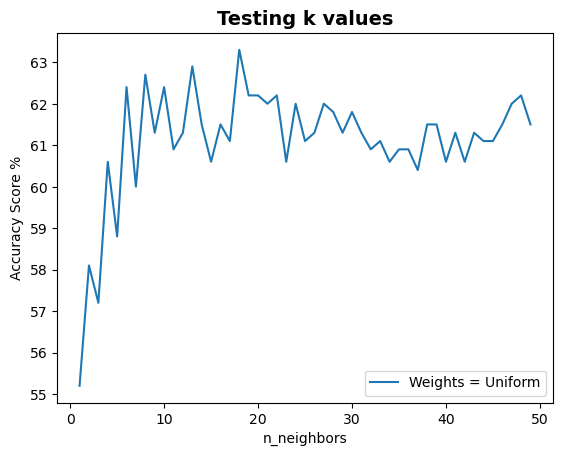

In [9]:
fig, ax = plt.subplots()
ax.plot(range(1, 50, 1), test_accuracy_compiled_av, label='Weights = Uniform')
ax.set_xlabel('n_neighbors')
ax.set_ylabel('Accuracy Score %')
ax.set_title('Testing k values', y=1, fontsize=14, fontweight='bold')
ax.legend(loc=4)
plt.savefig('ml_10_testing_k_values_uniform.png')
plt.show()

In [10]:
best_k = np.argmax(test_accuracy_compiled_av) + 1
best_accuracy = test_accuracy_compiled_av[best_k - 1]

print("Best k:", best_k)
print("Best accuracy score:", best_accuracy)

Best k: 18
Best accuracy score: 63.300000000000004


In [13]:
knn = KNeighborsClassifier(n_neighbors=18)
knn.fit(X_train, y_train)
preds = knn.predict(X_test)
confusion_matrix = confusion_matrix(y_test, preds) 
accuracy_score = accuracy_score(y_test, preds)
precision_score = precision_score(y_test, preds)
recall_score = recall_score(y_test, preds)
f1_score = f1_score(y_test, preds)
print("confusion matrix", confusion_matrix)
print("accuracy score: ", accuracy_score)
print("precision score: ", precision_score)
print("recall score: ", recall_score)
print("f1 score: ", f1_score)

confusion matrix [[228  37]
 [125  52]]
accuracy score:  0.6334841628959276
precision score:  0.5842696629213483
recall score:  0.2937853107344633
f1 score:  0.3909774436090226


In [18]:
skf = StratifiedKFold(n_splits=5, shuffle=True)
# Perform cross-validation
cv_scores = cross_val_score(knn, X_train, y_train, cv=skf)
cv_accuracy = round(np.mean(cv_scores) * 100, 1)

print('Cross-Validation Accuracy Score: ', cv_accuracy, '%')


Cross-Validation Accuracy Score:  63.3 %


In [19]:
cv_scores

array([0.61275272, 0.63239875, 0.65109034, 0.63395639, 0.63395639])

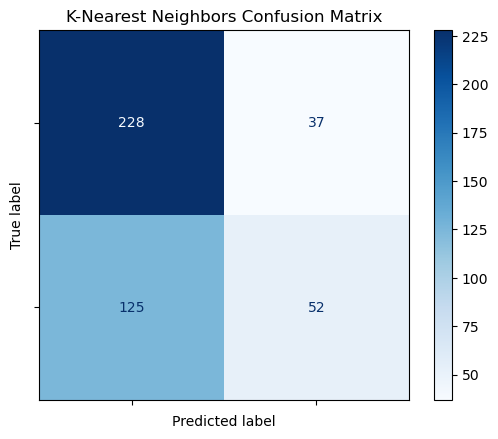

In [20]:
plot_cross_val_confusion_matrix(confusion_matrix, display_labels='', title='K-Nearest Neighbors Confusion Matrix', cv=5)
plt.show()

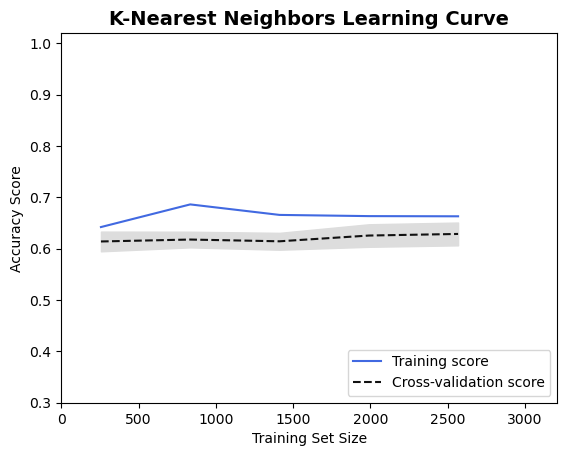

In [21]:
plot_learning_curve(knn, X_train, y_train, scoring='accuracy', training_set_size=5, cv=5, x_min=0, x_max=len(X_train), y_min=0.3, y_max=1.02, title='K-Nearest Neighbors Learning Curve', leg_loc=4)
plt.show()